# `014` Attention mechanisms (and dropout)

Requirements: 012 Recurrent neural networks

There is a problem with RNNs when dealing with sequential data. Imagine we're trying to summarize a text about "the **big** house" that has several sentences describing its features. Our RNN would treat each word individually and try to capture the context in the same way for every single word. However, we want our model to focus on specific parts of the input sequence while processing it.

For instance, when processing the sentence "That is a **big** house", we want our model to focus on the word "that" which refers to the specific house being described. We also want it to recognize that the adjective "big" is modifying the noun "house".

This is where **Attention mechanisms** come in. They allow us to selectively focus on certain parts of the input sequence while processing it, such as paying attention to specific nouns or adjectives. This helps resolve the ambiguity problem and allows us to model long-range dependencies much better.

In addition to Attention, we will also cover another important technique: **Dropout**. Dropout randomly sets a fraction of neurons during training, which prevents overfitting and improves generalization performance. By combining these two techniques, we can create more powerful and robust RNNs that are capable of handling complex sequential data.

Let's start by loading our already familiar language classification dataset.

In [1]:
from json import loads
from matplotlib import pyplot as plt
from string import ascii_letters, digits
from time import time
from unicodedata import category, normalize
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
vocabulary = ascii_letters + digits + ' .,;\'!'
c2i = {c: i for i, c in enumerate(vocabulary)}
i2c = {i: c for i, c in enumerate(vocabulary)}

def vectorize_sentence(s):
	return [c2i[c] for c in normalize('NFD', s) if category(c) != 'Mn' and c in vocabulary]

In [3]:
with open('custom-data/sentences.json', encoding='utf-8') as f:
	data = loads(f.read())

languages = list(data.keys())

X, Y = [], []
block_size = 32
for language, sentences in data.items():
	for sentence in sentences:
		sentence = vectorize_sentence(sentence)
		for i in range(len(sentence) - block_size + 1):
			X.append(sentence[i:i+block_size])
			Y.append(languages.index(language))
ix = torch.randperm(len(X))
X = torch.tensor([X[i] for i in ix], device=device)
Y = torch.tensor([Y[i] for i in ix], device=device)

print(f'Loaded {len(X)} sentences from {len(languages)} languages using {len(vocabulary)} different characters')
print(X[0], Y[0], '->', ''.join(i2c[i.item()] for i in X[0]), languages[Y[0]])

Loaded 6232944 sentences from 8 languages using 68 different characters
tensor([17, 12, 19, 62,  4,  4, 13, 62,  7,  4, 11,  3,  4, 17,  1, 11,  0, 20,
        22,  4, 62, 14, 15, 11, 14, 18, 18,  8, 13,  6, 62, 21]) tensor(5) -> rmt een helderblauwe oplossing v nl


Now, let's see an example of how attention works. The idea of this mechanism, is to provide with meaning to the tokens, using other tokens for that. They way it works is by modelling a system by which tokens communicate with each other:
* First, each token is multiplied by a matrix $W_k$ that transforms them into the **key vector**. This vector tells which information our token contains that can be useful to give context to others.
* Then, each token is multiplied by a matrix $W_q$ that transforms them into the **query vector**. This vector tells which information our token is looking for in others.
* By multiplying the key token of each vector with the query token of each other vector, we can obtain an **attention matrix**. In this matrix, the position $i, j$ tells how much information from the $j$-th token does the $i$-th token wants.
* Then, we don't give the information from the embedding directly, we first map the tokens into the **value space** by multipliying by a matrix $W_v$.
* Finally, by multiplying the value vectors by the attention matrix, we convert each token into a linear combination of every other token value.

Since $W_k$, $W_q$ and $W_v$ are learnable parameters, the idea of the attention matrix is that during the gradient descent our model learns how each token should communicate with each other based on its content. Let's see it in code with an example:

In [4]:
input = torch.tensor([vectorize_sentence('Hello, World!')])  # (batch_size=1, context_length=13)

embed_dim = 8
embeddings = torch.randn(len(vocabulary), embed_dim)  # (vocabulary_size, embedding_channels=8)
input = embeddings[input]  # (batch_size=1, context_length=13, embedding_channels=8)

head_size = 16
# key space mapping: what each has to offer
W_k = torch.randn(embed_dim, head_size)  # (embedding_channels=8, head_size=16)
# query space mapping: what each token is looking for
W_q = torch.randn(embed_dim, head_size)  # (embedding_channels=8, head_size=16)

k = input @ W_k  # (batch_size=1, context_length=13, head_size=16)
q = input @ W_q  # (batch_size=1, context_length=13, head_size=16)

# dot product of what each token is looking for and what each has to offer -> attention weights: how much each token should pay attention to each other token
# note that you swap the last two dimensions of k to make a square matrix of dot products
attention_weights = q @ k.transpose(-2, -1)  # (batch_size=1, context_length=13, context_length=13)
# now, divide it by the square root of the head size to make the dot products more stable
attention_weights /= head_size ** 0.5
# apply a softmax to make the attention weights sum to 1
attention_weights = attention_weights.softmax(dim=-1)  # (batch_size=1, context_length=13, context_length=13)

# value space: what each token is contributing
W_v = torch.randn(embed_dim, head_size)  # (embedding_channels=8, head_size=16)

v = input @ W_v  # (batch_size=1, context_length=13, head_size=16)

# weighted sum of what each token is contributing, based on how much each token should pay attention to each other token
output = attention_weights @ v  # (batch_size=1, context_length=13, head_size=16)

Now, let's make it into a pytorch layer:

In [5]:
class SimpleAttention(torch.nn.Module):
	def __init__(self, embedding_channels, head_size):
		super().__init__()
		self.W_k = torch.nn.Linear(embedding_channels, head_size, bias=False)
		self.W_q = torch.nn.Linear(embedding_channels, head_size, bias=False)
		self.W_v = torch.nn.Linear(embedding_channels, head_size, bias=False)
	def forward(self, x):
		k = self.W_k(x)
		q = self.W_q(x)
		attention = q @ k.transpose(-2, -1) / k.size(-1) ** 0.5
		attention = attention.softmax(dim=-1)
		v = self.W_v(x)
		return attention @ v

Notice we called it **simple** attention? This is because something that works well with attention is to have multiple layers like this stacked, in parallel. This way, each **attention head** (which is how we call each of them) is paying attention to a different feature. One might be looking for ways to disambiguate words like "that", while other might be looking for ways to give adjectives the context of which noun they refer to.

But since all those layers run in parallel, we risk that they all start paying attention to the same stuff. To avoid this, we are going to randomly deactivate some weights in the network, so that **not all neurons fire at once**. This technique is called **Dropout**, and it helps prevent overfitting by reducing the reliance on individual neurons.

In [6]:
class Dropout(torch.nn.Module):
	def __init__(self, ratio):
		super().__init__()
		self.ratio = ratio
	def forward(self, x):
		mask = (torch.rand_like(x) > self.ratio).float()
		return mask * x

Now that we have all the ingredients we need, let's create a MultiHeadAttention layer.

In [7]:
class MultiHeadAttention(torch.nn.Module):
	def __init__(self, embed_dim, num_heads, dropout_ratio):
		super().__init__()
		self.heads = torch.nn.ModuleList([
			SimpleAttention(embed_dim, embed_dim // num_heads)
			for _ in range(num_heads)
		])
		self.fc = torch.nn.Linear(embed_dim, embed_dim)
		self.dropout = Dropout(dropout_ratio)

	def forward(self, x):
		x = torch.cat([head(x) for head in self.heads], dim=-1)
		x = self.fc(x)
		x = self.dropout(x)
		return x

And let's place it in the RNN from the previous notebook, and test the result with and without it.

In [8]:
class RNN(torch.nn.Module):
	def __init__(self, input_size, output_size, use_attention=False, emb_dim=128, hidden_size=128, num_heads=4, dropout_ratio=.2):
		super().__init__()
		self.hidden_size = hidden_size
		self.tok_emb = torch.nn.Embedding(input_size, emb_dim)
		self.pos_emb = torch.nn.Embedding(block_size, emb_dim)
		self.attention = MultiHeadAttention(emb_dim, num_heads, dropout_ratio) if use_attention else None
		self.i2h = torch.nn.Linear(emb_dim, hidden_size)
		self.h2h = torch.nn.Linear(hidden_size, hidden_size)
		self.h2o = torch.nn.Linear(hidden_size, output_size)

	def forward(self, x):
		x = self.tok_emb(x) + self.pos_emb(torch.arange(x.size(-1)))
		if self.attention is not None: x = self.attention(x)
		hidden = torch.zeros(x.size(0), self.hidden_size, device=device)
		for i in range(input.size(1)):
			i = x[:, i]
			i = self.i2h(i)
			h = self.h2h(hidden)
			hidden = (h + i).tanh()
		return self.h2o(hidden)

model_with_attention = RNN(len(vocabulary), len(languages), use_attention=True).to(device)
print(f'Created model with attention and {sum(p.numel() for p in model_with_attention.parameters())} parameters')
model_without_attention = RNN(len(vocabulary), len(languages), use_attention=False, emb_dim=416).to(device)
print(f'Created model with no attention and {sum(p.numel() for p in model_without_attention.parameters())} parameters')

Created model with attention and 112520 parameters
Created model with no attention and 112520 parameters


To be fair in the comparison, we have given almost twice the embedding size to the model without attention, so that both have the same number of parameters.

In [9]:
def train(model, iterations=1000, batch_size=64, lr=3e-4):
	start = time()
	criterion = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	losses = []
	for i in range(iterations):
		ix = torch.randint(len(X), (batch_size,))
		xb, yb = X[ix], Y[ix]
		loss = criterion(model(xb), yb)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		losses.append(loss.item())
		if i % 100 == 0 and i > 0 or i == 10:
			remaining = (time() - start) * (iterations - i) / (i + 1)
			print(f'Epoch {i:4} loss: {loss.item():.4f} remaining: {remaining//60:.0f}:{remaining%60:02.0f}')
	return losses

def plot_losses(losses):
	losses_avg = torch.tensor(losses).view(-1, 10).mean(1)
	plt.figure(figsize=(10, 4))
	plt.plot(losses, c='c', label='loss')
	plt.plot(range(0, len(losses), 10), losses_avg, c='k', label='average loss')
	plt.xlabel('epoch')
	plt.ylabel('loss')
	plt.legend()
	plt.ylim(0, 3)
	plt.axvline(1000, c='gray', linestyle='--')
	plt.show()

def confusion_matrix(model):
	ix = torch.randint(len(X), (1000,))
	X_test, Y_test = X[ix], Y[ix]

	confusion_matrix = torch.zeros(len(languages), len(languages), device=device)
	output = model(X_test).argmax(1)
	for true_label, predicted_label in zip(Y_test, output):
		confusion_matrix[true_label, predicted_label] += 1
	confusion_matrix /= confusion_matrix.sum(1, keepdim=True)

	plt.imshow(confusion_matrix.cpu().numpy())
	plt.xticks(range(len(languages)), languages, rotation=90)
	plt.yticks(range(len(languages)), languages)
	plt.xlabel('predicted')
	plt.ylabel('actual')
	plt.show()

	accuracy = confusion_matrix.diag().sum().item() / len(Y_test)
	print(f'Accuracy: {100 * accuracy:.2f}%')

def train_and_evaluate(model):
	print('Training with default learning rate')
	losses = train(model)
	print('Training with lower learning rate')
	losses.extend(train(model, lr=3e-5))
	plot_losses(losses)
	confusion_matrix(model)

Now let's test both models!

Training with default learning rate
Epoch   10 loss: 2.0513 remaining: 0:45
Epoch  100 loss: 1.5457 remaining: 0:14
Epoch  200 loss: 1.5606 remaining: 0:12
Epoch  300 loss: 1.1924 remaining: 0:10
Epoch  400 loss: 1.0256 remaining: 0:08
Epoch  500 loss: 0.9739 remaining: 0:06
Epoch  600 loss: 1.0274 remaining: 0:05
Epoch  700 loss: 1.1097 remaining: 0:04
Epoch  800 loss: 1.0134 remaining: 0:02
Epoch  900 loss: 1.1121 remaining: 0:01
Training with lower learning rate
Epoch   10 loss: 1.0136 remaining: 0:10
Epoch  100 loss: 1.1116 remaining: 0:09
Epoch  200 loss: 1.0247 remaining: 0:09
Epoch  300 loss: 0.9383 remaining: 0:08
Epoch  400 loss: 1.0439 remaining: 0:07
Epoch  500 loss: 1.0306 remaining: 0:06
Epoch  600 loss: 1.1298 remaining: 0:05
Epoch  700 loss: 1.0109 remaining: 0:04
Epoch  800 loss: 1.1478 remaining: 0:02
Epoch  900 loss: 1.0497 remaining: 0:01


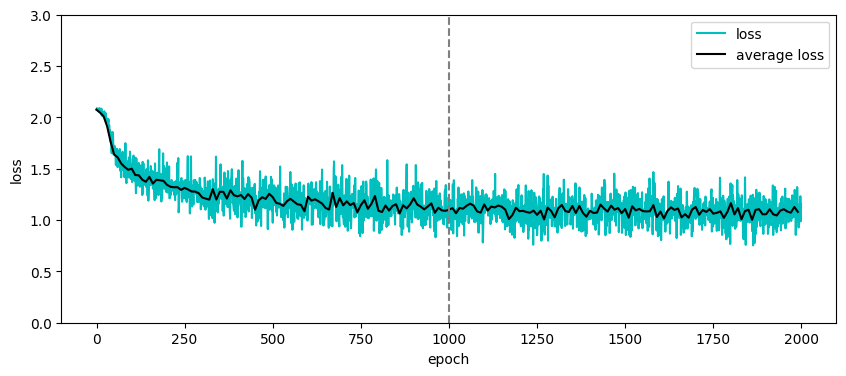

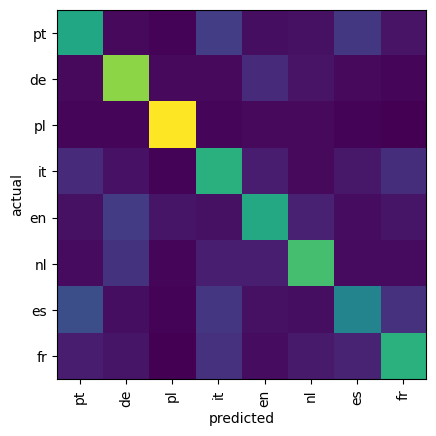

Accuracy: 0.49%


In [10]:
train_and_evaluate(model_with_attention)

Training with default learning rate
Epoch   10 loss: 2.1677 remaining: 0:11
Epoch  100 loss: 2.0910 remaining: 0:08
Epoch  200 loss: 1.9519 remaining: 0:07
Epoch  300 loss: 1.7211 remaining: 0:06
Epoch  400 loss: 1.7507 remaining: 0:05
Epoch  500 loss: 1.6197 remaining: 0:04
Epoch  600 loss: 1.4526 remaining: 0:04
Epoch  700 loss: 1.5885 remaining: 0:03
Epoch  800 loss: 1.5220 remaining: 0:02
Epoch  900 loss: 1.4550 remaining: 0:01
Training with lower learning rate
Epoch   10 loss: 1.3051 remaining: 0:08
Epoch  100 loss: 1.1356 remaining: 0:07
Epoch  200 loss: 1.2206 remaining: 0:07
Epoch  300 loss: 1.3887 remaining: 0:06
Epoch  400 loss: 1.2926 remaining: 0:05
Epoch  500 loss: 1.5237 remaining: 0:04
Epoch  600 loss: 1.2735 remaining: 0:03
Epoch  700 loss: 1.5132 remaining: 0:02
Epoch  800 loss: 1.2711 remaining: 0:02
Epoch  900 loss: 1.4579 remaining: 0:01


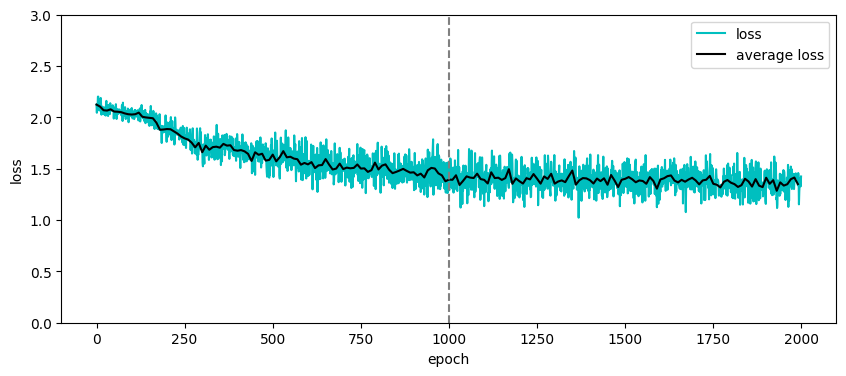

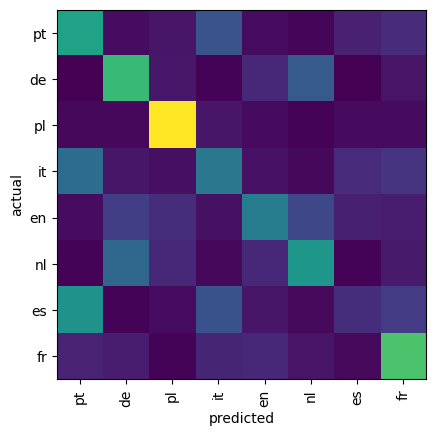

Accuracy: 0.37%


In [11]:
train_and_evaluate(model_without_attention)

Notice how fast the learning has been in this case! In a couple minutes, we get a model that can identify the language of a conversation to some extent (50% zero-shot accuracy). With longer training times, larger models and more data, we can get very reliable models with this architecture.